In practice, true stationarity or cointegration is rare. 
And even if the series is stationary, if the half-life for mean reversion is too long (e.g., 10 years), it will not be viable. 
However, we can capture short-term or seasonal mean reversion (time series that mean-revert only during specific periods of the day or under specific conditions), and liquidate our positions before the prices go to their nex equilibrium level. 


In [411]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from hurst import compute_Hc
from arch.unitroot import VarianceRatio

We trade a pair of stocks with price series $y_1, y_2$. We construct a portfolio $y$:

$$ y = y_1 - h y_2 $$

where we are long stock 1 and short $h$ units of stock 2. 

## Load price series

In [412]:
tickers = ['KO', 'PM']
period = '2y'
interval = '1h'

In [413]:
prices = [yf.Ticker(t).history(period=period, interval=interval)['Close'] for t in tickers]
prices_df = pd.DataFrame({ticker: price_series[(prices[0].index[:-1])] for ticker, price_series in zip(tickers, prices)})
prices_df

,KO,PM
2021-12-02 09:30:00-05:00,52.970001,88.217598
2021-12-02 10:30:00-05:00,52.948399,88.400002
2021-12-02 11:30:00-05:00,53.090000,88.459999
2021-12-02 12:30:00-05:00,53.169998,88.584999
2021-12-02 13:30:00-05:00,53.330002,88.669998
...,...,...
2023-12-01 11:30:00-05:00,58.505001,93.389999
2023-12-01 12:30:00-05:00,58.494999,93.699997
2023-12-01 13:30:00-05:00,58.599998,93.860001
2023-12-01 14:30:00-05:00,58.535000,94.035004


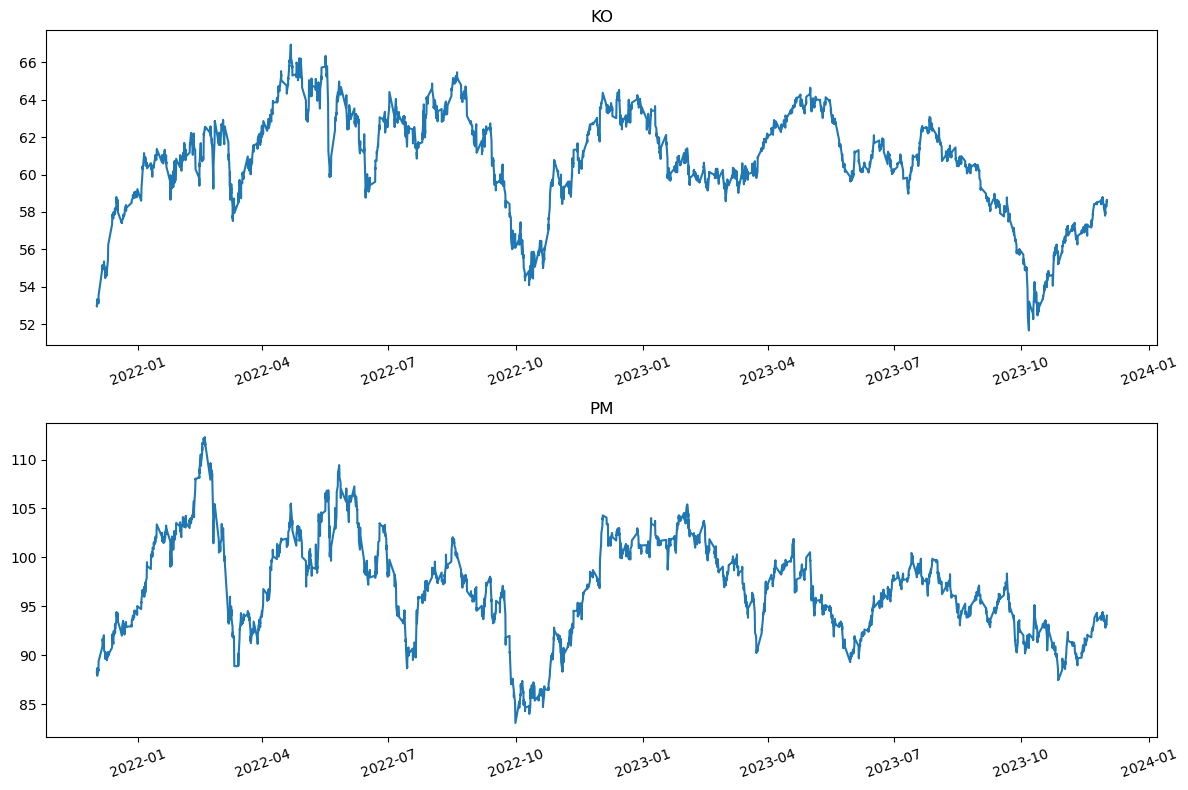

In [414]:
fig, axs = plt.subplots(len(prices), figsize=(12, 8))

for i in range(len(prices)):
    axs[i].plot(prices[i].index, prices[i])
    axs[i].set_title(tickers[i])
    axs[i].tick_params(axis='x', labelrotation=20)

plt.tight_layout()
plt.show()

## Create long/short pair portfolio

First we find the optimal hedge ratio through OLS regression. 

In [415]:
hedge_ratio = sm.OLS(prices[0][:-1], sm.add_constant(prices[1][:-1])).fit().params[1]
hedge_ratio

0.34858209845981464

Then we construct the optimally hedged portfolio.

<AxesSubplot: >

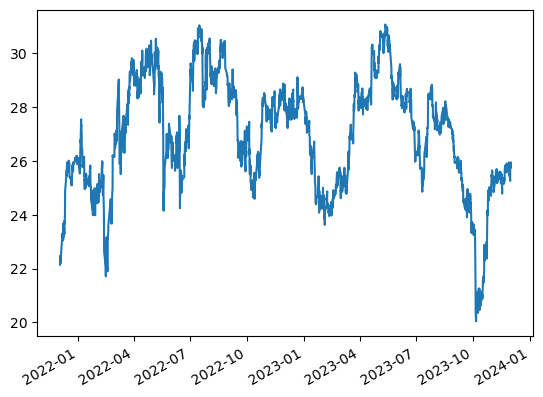

In [416]:
portfolio = (prices[0][:-1] - hedge_ratio * prices[1][:-1])
portfolio.plot()

## Test mean-reversion of portfolio

First we perform an Augmented Dickey-Fuller (ADF) test on the two portfolios, which indicates that the portfolio is stationary. 

In [417]:
adfuller(portfolio)

(-3.4417291791082327,
 0.009615963447904897,
 1,
 3510,
 {'1%': -3.432214412758864,
  '5%': -2.8623637918854077,
  '10%': -2.5672085185996867},
 -891.4192488261106)

We see that the Hurst exponent for the portfolio is $<1/2$, which indicates antipersistence and mean-reversion. 

In [418]:
compute_Hc(portfolio)

(0.43009259799419186,
 1.7494295490158012,
 [[10, 17, 31, 56, 100, 177, 316, 562, 1000, 1778, 3162, 3512],
  [3.8725377966488623,
   5.263888535236514,
   7.112450322925282,
   10.246870237062387,
   14.145560592237729,
   19.566752082499672,
   27.344224958485423,
   33.25131048352602,
   35.91440275047237,
   38.651548691270655,
   43.755947512970465,
   51.7843452958089]])

We also conduct a variance ratio test where we see that we can't reject the null hypothesis that the variance is constant over time for significance $0.05$. 

In [419]:
print(VarianceRatio(portfolio).summary().as_text())

     Variance-Ratio Test Results     
Test Statistic                  0.995
P-value                         0.320
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)


## Half-life

If we transform the discrete time series from above to a differential form so that the changes in prices becomes infinitesimal quantities (and ignore the drift $\beta_t$ and the lagged differences $\Delta R(t-1), ..., \Delta R(t-k)$) then it becomes recognizable as the Ornstein-Uhlenbeck formula for a mean-reverting process
$$ d R(t) = (\lambda R(t-1) + \mu)dt + d\epsilon $$
where $d \epsilon$ is some Gaussian noise. 
We find the $\lambda$ using the ADF test, where we apply linear regression of $\Delta R(t)$ against $R(t-1)$, and this value carries over to the differential form. 
The analytical solution for the expected value of $R(t)$ is
$$ E[R(t)] = R_0 \exp{(\lambda t)} - \mu / \lambda (1-\exp{(\lambda t)}) $$

Since $\lambda$ is negative for a mean-reverting process, the expected value of the price decays exponentially to the value $-\mu/\lambda$ with the half-life of decay equal to $-\log{(2)}/\lambda$. 
Therefore, a mean-reverting strategy will not work if $\lambda>0$. 
Furthermore, if $\lambda$ is very close to zero, this means that the half-life will be very long, and a mean-reverting strategy will not be very profitable because we won't be able to complete many round-trip trades in a given time period. 
Lastly, $\lambda$ determines a natural time scale for many parameters in our strategy. Often, setting the look-back to equal a small multiple ($\geq 1$) of the half-life is close to optimal. 

In [420]:
def get_halflife(y): 
    ylag = np.roll(y, 1)
    deltaY = y - ylag
    deltaY = deltaY[1:]
    ylag = ylag[1:]
    X = np.column_stack((ylag, np.ones(len(ylag))))
    ols_model = sm.OLS(deltaY, X).fit()
    beta_1 = ols_model.params[0]
    halflife = -np.log(2) / beta_1
    return halflife

In [421]:
lookback = int(get_halflife(portfolio))
lookback

122

## Bollinger Bands

We enter into a position when the price deviates by more than $entryZscore$ standard deviations from the mean (computed within a look-back period or equal to the half-life of mean reversion). 

We exit when the price mean-reverts to $exitZscore$ standard deviations from the mean, where $exitZscore < entryZscore$. 

If $exitZscore=0$, we exit when the price mean-reverts to the current mena. 
If $exitZscore=-entryZscore$, we exit when the price moves beyond the opposite band so as to trigger a trading signal of the opposite sign. 

At any one time, we can have either zero or one unit (long or short) invested. 


In [422]:
entryZscore = 1
exitZscore = 0

In [423]:
zScore = pd.DataFrame(((portfolio - portfolio.rolling(window=lookback).mean()) / portfolio.rolling(window=lookback).std()), index=portfolio.index)
zScore

,Close
2021-12-02 09:30:00-05:00,NaN
2021-12-02 10:30:00-05:00,NaN
2021-12-02 11:30:00-05:00,NaN
2021-12-02 12:30:00-05:00,NaN
2021-12-02 13:30:00-05:00,NaN
...,...
2023-12-01 11:30:00-05:00,1.950794
2023-12-01 12:30:00-05:00,1.424261
2023-12-01 13:30:00-05:00,1.599006
2023-12-01 14:30:00-05:00,1.054633


In [424]:
longsEntry = zScore < -entryZscore
longsExit = zScore >= -exitZscore
shortsEntry = zScore > entryZscore
shortsExit = zScore <= exitZscore

We find the long entries and exits

<AxesSubplot: >

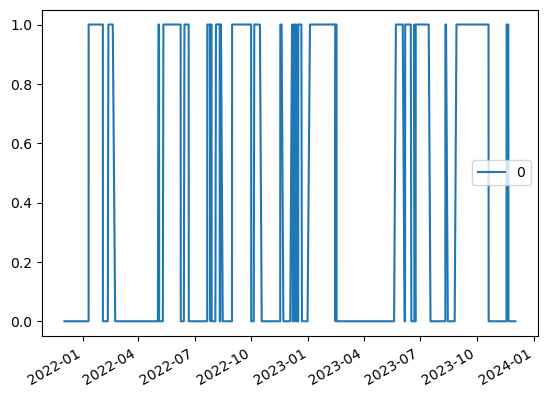

In [425]:
numUnitsLong = np.full((len(portfolio), 1), np.nan)
numUnitsLong[0] = 0
numUnitsLong[longsEntry] = 1
numUnitsLong[longsExit] = 0
numUnitsLong = pd.DataFrame(numUnitsLong, index=portfolio.index).ffill()#.to_numpy()
numUnitsLong.plot()

We find the short entries and exits 

<AxesSubplot: >

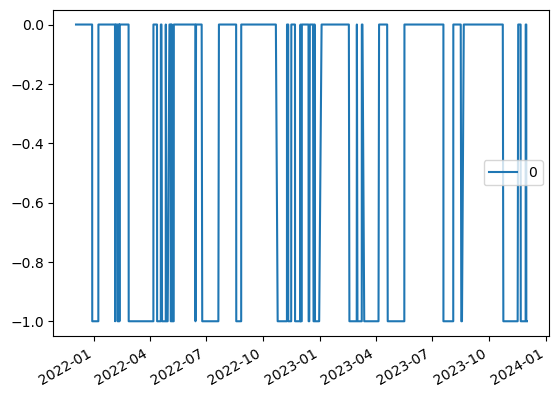

In [426]:
numUnitsShort = np.full((len(portfolio), 1), np.nan)
numUnitsShort[0] = 0
numUnitsShort[shortsEntry] = -1
numUnitsShort[shortsExit] = 0
numUnitsShort = pd.DataFrame(numUnitsShort, index=portfolio.index).ffill()#.to_numpy()
numUnitsShort.plot()

We then combine the long and short entries and exits to form our holdings of the portfolio. 

<AxesSubplot: >

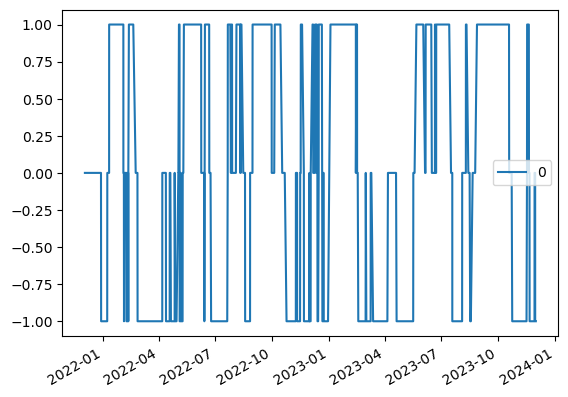

In [427]:
numUnits = numUnitsLong + numUnitsShort
numUnits.plot()

Following this strategy produces the following returns. 

<AxesSubplot: >

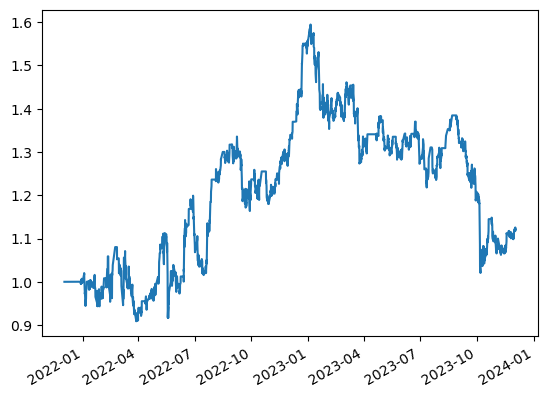

In [428]:
pnl = portfolio.pct_change(1)[1:] # the returns of the portfolio
pnl *= numUnits[:-1].values.flatten() # times our position
pnl = pnl.add(1).cumprod() # getting the cumulative product of our returns
pnl.plot()

## Kalman Filter